<a href="https://colab.research.google.com/github/hgaiji/EDAR/blob/develop/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのインポート
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 入力画像の次元
img_shape = (img_rows, img_cols, channels)

# 生成器の入力として使われるノイズベクトルの生成
z_dim = 100

In [ ]:
# 生成器
def build_generator(img_shape, z_dim):

    model = Sequential()

    # 全結合層
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU による活性化関数
    model.add(LeakyReLU(alpha=0.01))

    #  tanh 関数を使った出力層
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # 生成器の出力が画像サイズになるように　reshapeする
    model.add(Reshape(img_shape))

    return model

In [ ]:
# 識別器
def build_discriminator(img_shape):

    model = Sequential()

    # 入力画像を一列に並べる
    model.add(Flatten(input_shape=img_shape))

    # 全結合層
    model.add(Dense(128))

    # Leaky ReLU による活性化関数
    model.add(LeakyReLU(alpha=0.01))

    # sigmoid 関数を通して出力する
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:

def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別器の統合
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# 識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 生成器の構築
generator = build_generator(img_shape, z_dim)

# 生成器の構築中は識別器のパラメータを固定
discriminator.trainable = False

# 生成器の訓練のため、識別器は固定し、GANモデルの構築とコンパイルを行う
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST datasetをロード
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] の範囲のグレースケール画素値を [-1, 1]　にスケーリング
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 本物の画像のラベルはすべて１とする
    real = np.ones((batch_size, 1))

    # 偽物の画像のラベルはすべて０とする
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  識別器の訓練
        # -------------------------

        # 本物の画像をランダムに取り出したバッチを作る
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 偽物の画像のバッチを生成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 識別器の訓練
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  生成器の訓練
        # ---------------------

        # 偽物の画像のバッチを生成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 生成器の訓練
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 訓練終了後に図示するために、損失と精度をセーブしておく
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 訓練の進捗を出力する
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 生成された画像のサンプルを出力する
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # ランダムノイズのサンプリング ( np.random.normal : 正規分布に従う乱数を返す)
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # ランダムノイズを使って画像を生成する
    gen_imgs = generator.predict(z)
    # gen_imgs
    #　画像の画素値を[0, 1]の範囲にスケールする
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 画像をグリッドに並べる
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 並べた画像を出力する
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.032643, acc.: 100.00%] [G loss: 3.986958]
2000 [D loss: 0.068005, acc.: 97.66%] [G loss: 6.830101]
3000 [D loss: 0.105730, acc.: 96.88%] [G loss: 5.387388]
4000 [D loss: 0.187883, acc.: 92.97%] [G loss: 4.467778]
5000 [D loss: 0.179146, acc.: 92.97%] [G loss: 5.075186]
6000 [D loss: 0.259576, acc.: 86.72%] [G loss: 4.043094]
7000 [D loss: 0.283910, acc.: 87.50%] [G loss: 3.909041]
8000 [D loss: 0.337458, acc.: 87.11%] [G loss: 3.214091]
9000 [D loss: 0.325173, acc.: 84.77%] [G loss: 3.409014]
10000 [D loss: 0.626968, acc.: 76.95%] [G loss: 2.375452]
11000 [D loss: 0.415886, acc.: 84.38%] [G loss: 3.287671]
12000 [D loss: 0.483636, acc.: 80.47%] [G loss: 2.537323]
13000 [D loss: 0.397052, acc.: 81.64%] [G loss: 2.848011]
14000 [D loss: 0.670345, acc.: 70.70%] [G loss: 2.121195]
15000 [D loss: 0.382433, acc.: 80.86%] [G loss: 2.213540]
16000 [D loss: 0.244061, acc.: 91.41%] [G loss: 2.730865]
17000 [D loss: 

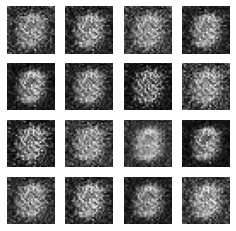

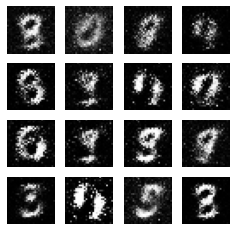

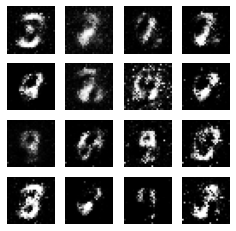

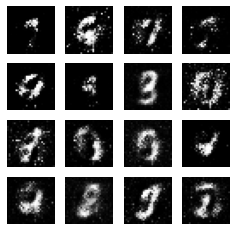

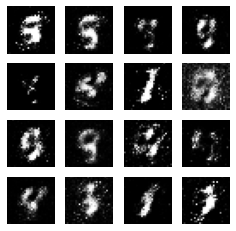

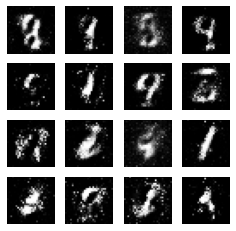

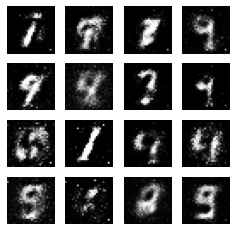

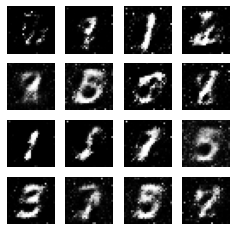

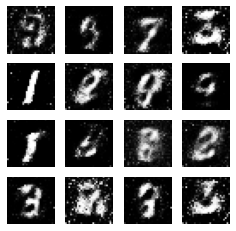

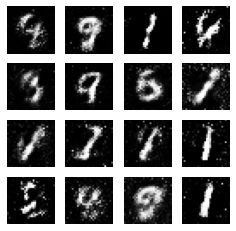

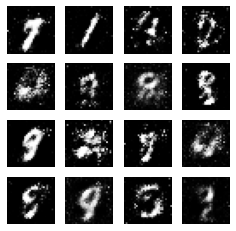

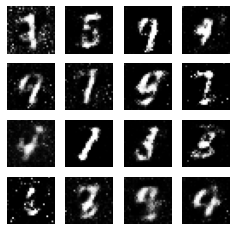

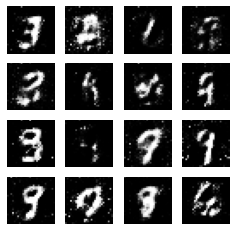

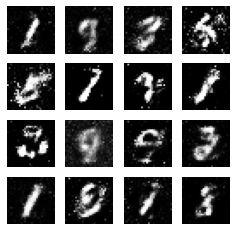

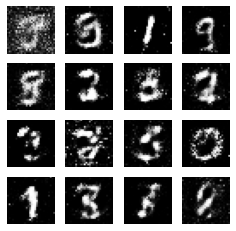

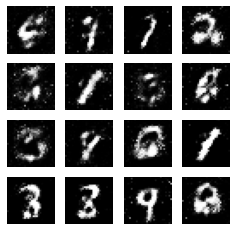

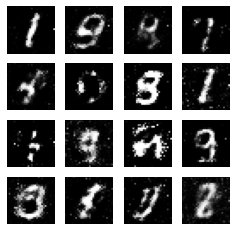

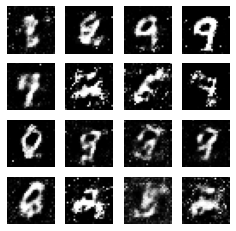

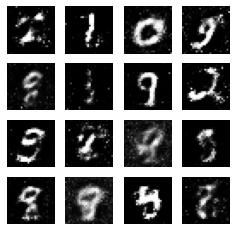

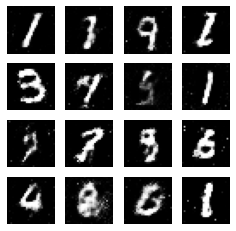

In [ ]:

# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)